# __Importerar bibliotek__

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC


# __Hämtar MNIST-data__

In [4]:
mnist = fetch_openml('mnist_784', version = 1, cache = True, as_frame = False)
print (mnist.DESCR)

X = mnist["data"].astype("float32")
y = mnist["target"].astype(int)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

# __Preprocessing/Förbehandling__

In [5]:
# Delar upp i train, validation, test

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=10000, random_state=42, stratify=y)  # stratify - att varje siffra (0–9) får ungefär samma andel i varje låda.
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=10000, random_state=42, stratify=y_train_val)

preprocessor = StandardScaler()


# __EDA__


Träning - antal per siffra: 
0: 4931 (9.9%)
1: 5627 (11.3%)
2: 4992 (10.0%)
3: 5101 (10.2%)
4: 4874 (9.7%)
5: 4509 (9.0%)
6: 4912 (9.8%)
7: 5209 (10.4%)
8: 4875 (9.8%)
9: 4970 (9.9%)

Validering - antal per siffra: 
0: 986 (9.9%)
1: 1125 (11.2%)
2: 999 (10.0%)
3: 1020 (10.2%)
4: 975 (9.8%)
5: 902 (9.0%)
6: 982 (9.8%)
7: 1042 (10.4%)
8: 975 (9.8%)
9: 994 (9.9%)


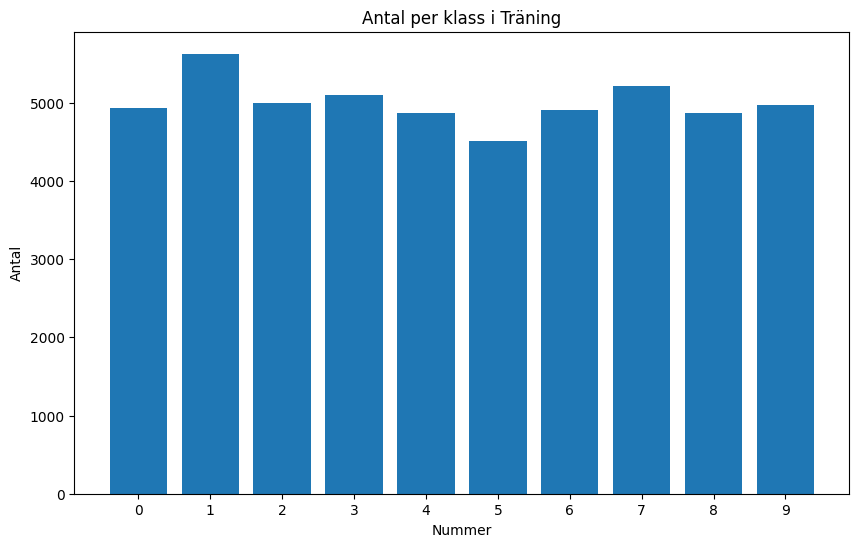

In [58]:
# Visar fördelning av klasser, antal per siffra på train- och val-data. Ser ut att vara balanserat.

def class_summary(y, name): 
    counts = np.bincount(y, minlength=10)
    total = counts.sum()
    pct = counts / total * 100
    print(f"\n{name} - antal per siffra: ")
    for digit in range(10): 
        print(f"{digit}: {counts[digit]} ({pct[digit]:.1f}%)")

class_summary(y_train, "Träning")
class_summary(y_val, "Validering")

counts_train = np.bincount(y_train, minlength=10)

plt.figure(figsize=(10, 6))
plt.bar(range(10), counts_train)
plt.xticks(range(10))
plt.title("Antal per klass i Träning")
plt.xlabel("Nummer")
plt.ylabel("Antal")
plt.show()

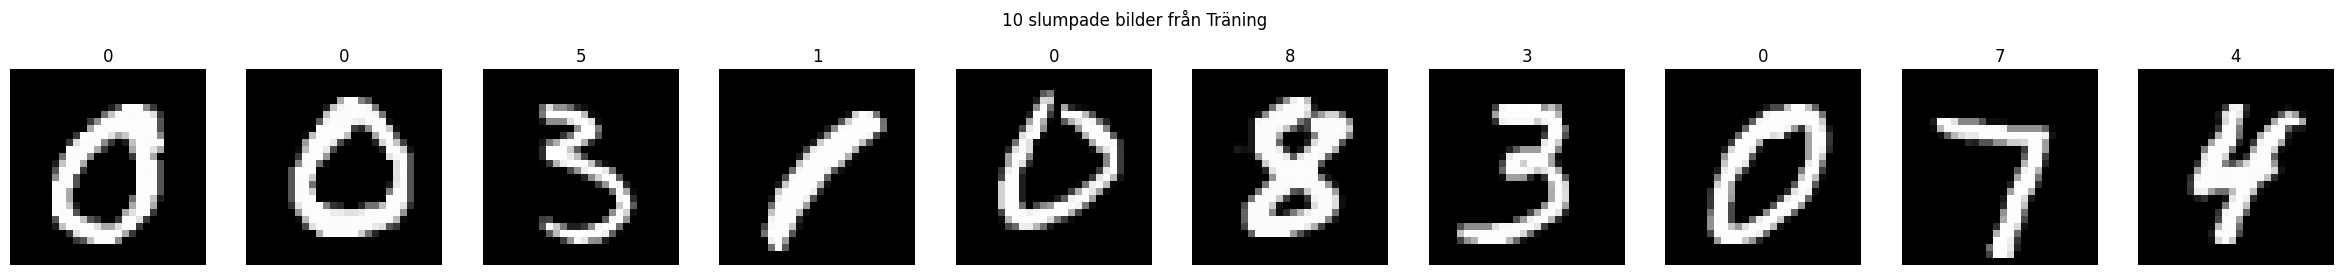

In [59]:
# Visar ut slumpade siffror för att undersöka hur data-setet ser ut. 

random_numbers = np.random.choice(len(X_train), 10, replace=False)

plt.figure(figsize=(30, 30))
for i, j in enumerate(random_numbers, 1):
    plt.subplot(10, 10, i)
    plt.imshow(X_train[j].reshape(28, 28), cmap="grey")
    plt.title(str(y_train[j]))
    plt.axis("off")
plt.suptitle("10 slumpade bilder från Träning", y=0.9)
plt.show()

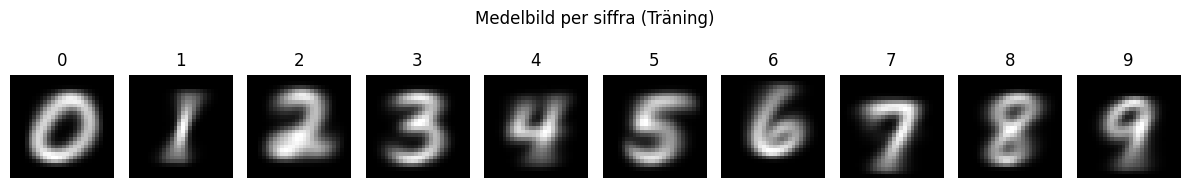

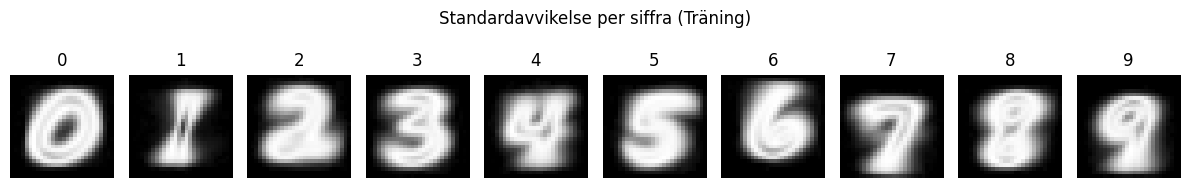

In [60]:
# Visar ut medelbild (typisk form för varje siffra) och standardavvikelse (hur mycket pixlarna varierar inom samma siffra) för att förstå datasetets mönster och var variationen är störst, vilket kan vara extra svårt för modeller att lära sig

def plot_per_digit_images(X, y, agg="mean", title=""):
    plt.figure(figsize=(12, 2))
    for digit in range(10):
        data = X[y == digit]
        img = getattr(data, agg)(axis=0).reshape(28, 28)  # mean eller std

        plt.subplot(1, 10, digit + 1)
        plt.imshow(img, cmap="gray")
        plt.title(digit)
        plt.axis("off")

    plt.suptitle(title, y=1)
    plt.tight_layout()
    plt.show()

plot_per_digit_images(X_train, y_train, agg="mean", title="Medelbild per siffra (Träning)")
plot_per_digit_images(X_train, y_train, agg="std",  title="Standardavvikelse per siffra (Träning)")


# __Modellträning__

------------------------------------------------------------------------------------------------------------------------------------
#### __LogisticRegression__
- LogisticRegression utan GridSearchCV: VAL accuracy: 0.9166
- LogisticRegression med GridSearchCV: Bästa C: {'model__C': 0.01}, Bästa CV-accuracy: 0.92086, VAL accuracy (best): 0.9269
__Slutsats:__ Låg accuracy, 0,917-0,927, finns modeller som presterar bättre, lägger inte mer tid på denna. 

VAL accuracy (best): 0.9166


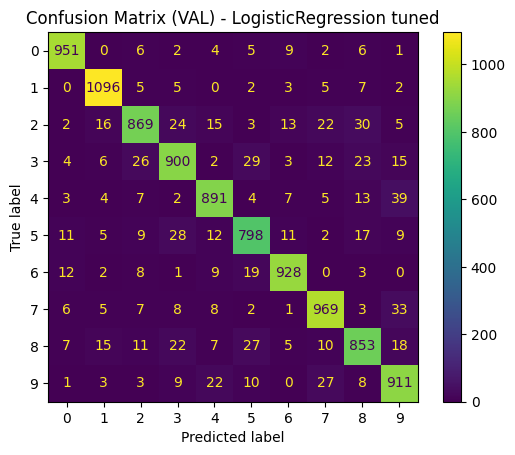

In [43]:
pipe_lr = Pipeline([
    ("prep", preprocessor),
    ("model", LogisticRegression(max_iter=4000, solver="lbfgs"))
])


pipe_lr.fit(X_train, y_train)

# VAL-utvärdering
y_val_pred = pipe_lr.predict(X_val)
print("VAL accuracy (best):", accuracy_score(y_val, y_val_pred))

cm = confusion_matrix(y_val, y_val_pred)
ConfusionMatrixDisplay(cm).plot(values_format="d")
plt.title("Confusion Matrix (VAL) - LogisticRegression tuned")
plt.show()

Bästa C: {'model__C': 0.01}
Bästa CV-accuracy: 0.92086
VAL accuracy (best): 0.9269


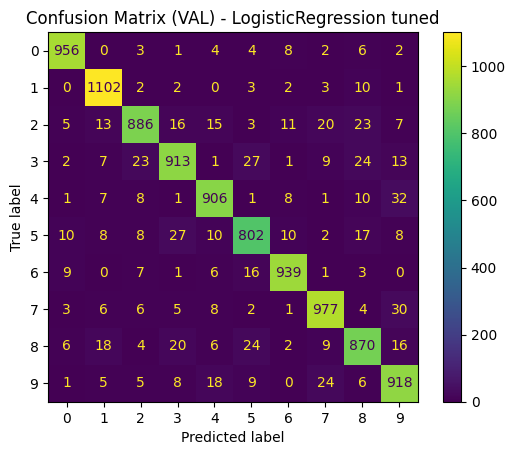

In [ ]:
pipe_lr_gs = Pipeline([
    ("prep", preprocessor),
    ("model", LogisticRegression(max_iter=4000, solver="lbfgs"))
])

hyperparam_grid_lr = {
    "model__C": [0.01, 0.05, 0.1, 0.2]
}

gs_lr = GridSearchCV(
    estimator=pipe_lr_gs,
    param_grid=hyperparam_grid_lr,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

gs_lr.fit(X_train, y_train)

print("Bästa C:", gs_lr.best_params_)
print("Bästa CV-accuracy:", gs_lr.best_score_)

best_model = gs_lr.best_estimator_

# VAL-utvärdering
y_val_pred = best_model.predict(X_val)
print("VAL accuracy (best):", accuracy_score(y_val, y_val_pred))

cm = confusion_matrix(y_val, y_val_pred)
ConfusionMatrixDisplay(cm).plot(values_format="d")
plt.title("Confusion Matrix (VAL) - LogisticRegression tuned")
plt.show()

------------------------------------------------------------------------------------------------------------------------------------
#### __RandomForest__
- RandomForest utan GridSearchCV: __VAL accuracy = 0.9724__
- RandomForest med GridSearchCV (bästa params: max_depth=20, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, n_estimators=500): __VAL accuracy = 0.9697__

__Slutsats:__ Hyperparametrar för RandomForest otptimerades med GridSearchCV på ett slumpmässigt subset av träningsdatan för att klara av beräkningen på laptop. I mina tester gav RandomForest med standardinställningar högst VAL accuracy, både med och utan optimering av hyperparameteroptimering. Ingen tydlig förbättring med tuning av hyperparametrar. Det tyder på att standardparametrar redan är bra för detta dataset, att ytterligare tuning ger begränsad effekt i förhållande till den ökade beräkningskostnaden (upplevde att det tog mycket mer kapacitet från datorn vid tuning jämfört med standardvärden).

VAL accuracy (RandomForest): 0.9724


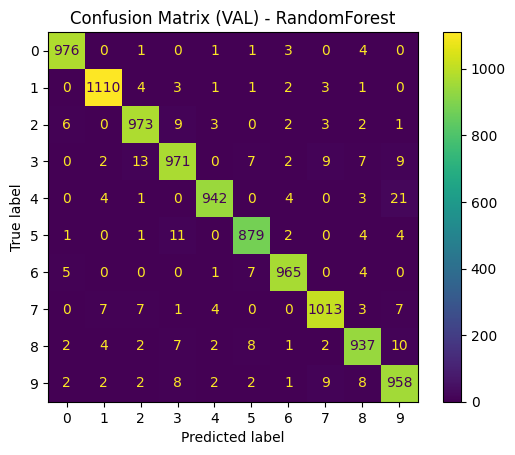

In [ ]:
rf = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)

rf.fit(X_train, y_train)

y_val_pred = rf.predict(X_val)
print("VAL accuracy (RandomForest):", accuracy_score(y_val, y_val_pred))

cm = confusion_matrix(y_val, y_val_pred)
ConfusionMatrixDisplay(cm).plot(values_format="d")
plt.title("Confusion Matrix (VAL) - RandomForest")
plt.show()

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Bästa RF params (subset): {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Bästa RF CV-accuracy (subset): 0.9537999922686135
OOB score (subset): 0.9574
VAL accuracy (retrain full): 0.9697


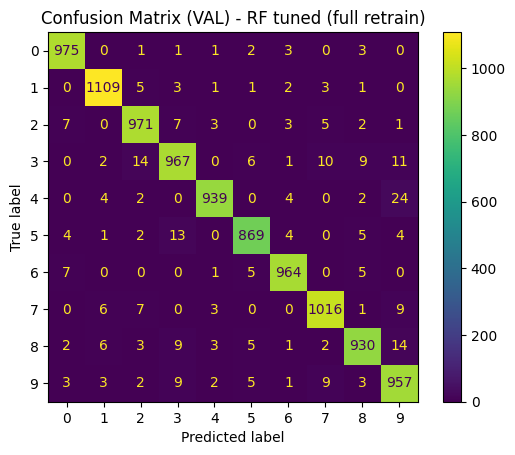

In [ ]:
random = np.random.RandomState(42)
n_sub = min(20000, X_train.shape[0]) 
idx = random.choice(X_train.shape[0], size=n_sub, replace=False) 

# Delar upp x och y i slumpmässigt subset för att kunna köra GridSearchCV snabbare på laptop
X_train_sub = X_train[idx] 
y_train_sub = y_train[idx] 

pipe_rf = RandomForestClassifier( 
    random_state=42, 
    n_jobs=1, bootstrap=True, 
    oob_score=True 
) 

# Hyperparameter-sökning på subset för att snabbare hitta rimliga inställningar för hyperparametrarna
hyperparam_grid_rf = { 
    "n_estimators": [300, 500], 
    "max_depth": [20, 30], 
    "max_features": ["sqrt"], 
    "min_samples_leaf": [1], 
    "min_samples_split": [2] 
} 

gs_rf = GridSearchCV( 
    estimator=pipe_rf, 
    param_grid=hyperparam_grid_rf, 
    cv=3, scoring="accuracy", 
    n_jobs=2, 
    verbose=2 
) 

gs_rf.fit(X_train_sub, y_train_sub) 

print("Bästa RF params (subset):", gs_rf.best_params_) 
print("Bästa RF CV-accuracy (subset):", gs_rf.best_score_) 
print("OOB score (subset):", getattr(gs_rf.best_estimator_, "oob_score_", None)) 

# Tränar om modell på hela träningsdatan med bästa parametrar från subset-sökningen
best_params = gs_rf.best_params_ 

rf_gs_full = RandomForestClassifier( 
    random_state=42, 
    n_jobs=1, bootstrap=True, 
    max_samples=0.8, 
    n_estimators=best_params["n_estimators"], 
    max_depth=best_params["max_depth"], 
    max_features=best_params["max_features"], 
    min_samples_leaf=best_params["min_samples_leaf"], 
    min_samples_split=best_params["min_samples_split"] 
) 

rf_gs_full.fit(X_train, y_train) 

y_val_pred = rf_gs_full.predict(X_val) 
val_acc = accuracy_score(y_val, y_val_pred) 
print("VAL accuracy (retrain full):", val_acc) 

cm = confusion_matrix(y_val, y_val_pred) 
ConfusionMatrixDisplay(cm).plot(values_format="d") 
plt.title("Confusion Matrix (VAL) - RF tuned (full retrain)") 
plt.show()

VAL accuracy (RandomForest final): 0.9697


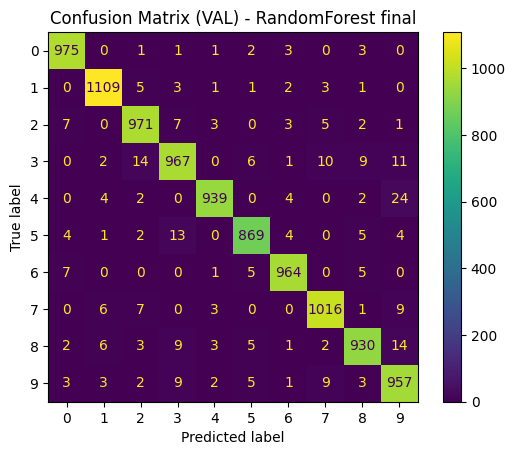

In [ ]:
# Slutgiltigt test: tränar RandomForest med de bästa hyperparametrarna från föregående tuning (samma resultat eftersom jag använder samma hyperparametrar men snabbare träning av modellen).
pipe_rf_final = RandomForestClassifier(
    random_state=42,
    n_jobs=1,
    bootstrap=True,
    max_samples=0.8,
    n_estimators=500,
    max_depth=20,
    max_features="sqrt",
    min_samples_leaf=1,
    min_samples_split=2
)

pipe_rf_final.fit(X_train, y_train)

y_val_pred = pipe_rf_final.predict(X_val)

val_acc = accuracy_score(y_val, y_val_pred)
print("VAL accuracy (RandomForest final):", val_acc)

cm = confusion_matrix(y_val, y_val_pred)
ConfusionMatrixDisplay(cm).plot(values_format="d")
plt.title("Confusion Matrix (VAL) - RandomForest final")
plt.show()


------------------------------------------------------------------------------------------------------------------------------------
### LinearSVC
- LinearSVC (med C=1.0, max_iter=6000, tol=1e-3,dual="auto")): __VAL accuracy = 0.9137__

__Slutsats:__  LinearSVC tar alldeles för mycket lång tid och ger för dåligt resultat (låg acuracy) för att jag ska välja att gå vidare med modellen. 

VAL accuracy (LinearSVC): 0.9137


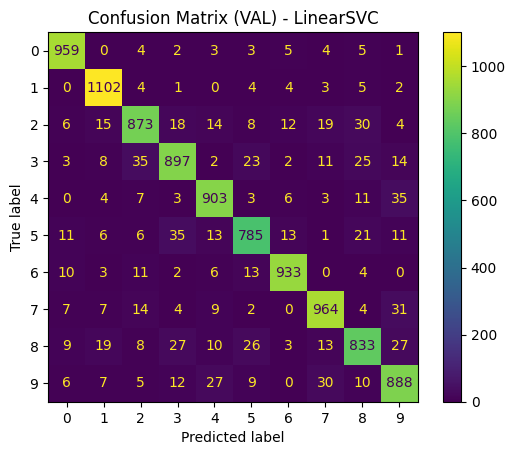

In [ ]:
pipe_lsvc = Pipeline([
    ("prep", preprocessor),
    ("model", LinearSVC(C=1.0, max_iter=6000, tol=1e-3,dual="auto", random_state=42)) # har fått optimera bort tol=1e-3, dual="auto", minskat max_iter för att få modellen att köra klart inom rimlig tid. Testat mer bredd men tar då över 1h att köra och det hinner inte ens gå klart på min laptop. 
])

pipe_lsvc.fit(X_train, y_train)

y_val_pred = pipe_lsvc.predict(X_val)
print("VAL accuracy (LinearSVC):", accuracy_score(y_val, y_val_pred))

cm = confusion_matrix(y_val, y_val_pred)
ConfusionMatrixDisplay(cm).plot(values_format="d")
plt.title("Confusion Matrix (VAL) - LinearSVC")
plt.show()

------------------------------------------------------------------------------------------------------------------------------------
#### __SVC__
- SVC utan GridSearchCV (RBF + PCA): __VAL accuracy (SVC): 0.9656__
- SVC med GridSearchCV (stegvis tuning av C, gamma och PCA): VAL accuracy (SVC tuned): ~0.9795–0.9796 (Bästa parametrar: PCA=75, gamma="scale", C=14): __VAL accuracy (SVC): 0.9795__

__Slutsats:__  SVC med RBF-kärna presterade stabilt och gav hög VAL-accuracy runt 0,9795. GridSearchCV gav bara en marginell förbättring jämfört med en rimlig standardinställning, och den bästa modellen blev PCA=75 + gamma="scale" + C=14. Med hänsyn till begränsade resurser på laptop avgränsades sökutrymmet, men resultaten var konsekventa över flera tester. 

VAL accuracy (SVC): 0.9656


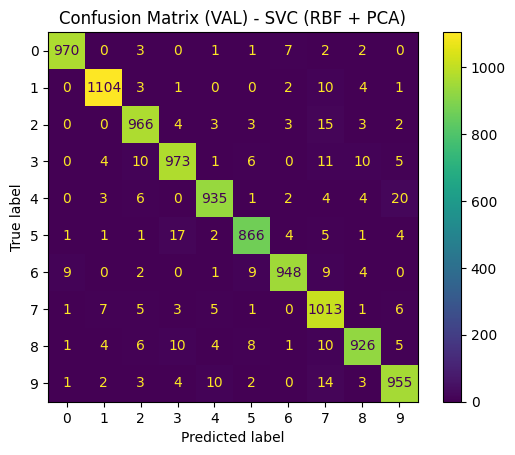

In [63]:
pipe_svc = Pipeline([
    ("scaler", preprocessor),
    ("svc", SVC(random_state=42))
])

pipe_svc.fit(X_train, y_train)

y_val_pred = pipe_svc.predict(X_val)
print("VAL accuracy (SVC):", accuracy_score(y_val, y_val_pred))

cm = confusion_matrix(y_val, y_val_pred)
ConfusionMatrixDisplay(cm).plot(values_format="d")
plt.title("Confusion Matrix (VAL) - SVC")
plt.show()


##### Tränar modell för att få fram bästa PCA med GridSearchCV (kör i olika steg i och med prestandabegränsningar i laptop).

In [ ]:
pipe_svc_gs_pca = Pipeline([
    ("scaler", preprocessor),
    ("pca", PCA(random_state=42)),
    ("model", SVC(kernel="rbf", C=10, gamma="scale", cache_size=2000))
])

hyperparams_grid_svc_pca = {
    "pca__n_components": [75, 76]
}

gs_svc_pca = GridSearchCV(
    estimator=pipe_svc_gs_pca,
    param_grid=hyperparams_grid_svc_pca,
    cv=3,
    scoring="accuracy",
    n_jobs=2,
    pre_dispatch=2,
    verbose=2,
    return_train_score=False
)

gs_svc_pca.fit(X_train, y_train)

BEST_PCA = gs_svc_pca.best_params_["pca__n_components"]
print("STEG 1 - Bästa PCA:", BEST_PCA)
print("STEG 1 - Bästa CV-accuracy:", gs_svc_pca.best_score_)



Fitting 3 folds for each of 2 candidates, totalling 6 fits
STEG 1 - Bästa PCA: 75
STEG 1 - Bästa CV-accuracy: 0.9729999087765755


##### Tränar modell för att få fram bästa gamma och C med GridSearchCV (kör i olika steg i och med prestandabegränsningar i laptop). 

Fitting 3 folds for each of 9 candidates, totalling 27 fits

STEG 2 - Bästa params: {'model__C': 10, 'model__gamma': 'scale'}
STEG 2 - Bästa CV-accuracy: 0.9729999087765755

STEG 3 - Slutmodellparametrar:
PCA n_components: 75
C: 10
gamma: scale
VAL accuracy (final): 0.9794


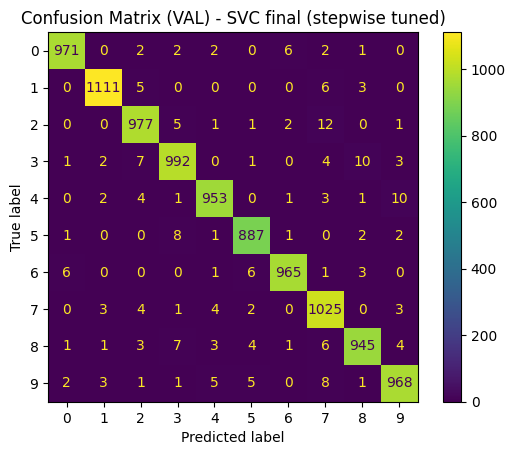

In [ ]:

BEST_PCA = 75

# Hitta bästa gamma + C (med PCA låst)
pipe_svc_gs_gamma = Pipeline([
    ("scaler", preprocessor),
    ("pca", PCA(BEST_PCA, random_state=42)),
    ("model", SVC(kernel="rbf", cache_size=2000))
])

hyperparams_grid_svc_gamma = {
    "model__C": [3, 10, 30],
    "model__gamma": ["scale", 0.01, 0.03]
}

gs_svc_gamma = GridSearchCV(
    estimator=pipe_svc_gs_gamma,
    param_grid=hyperparams_grid_svc_gamma,
    cv=3,
    scoring="accuracy",
    n_jobs=2,
    pre_dispatch=2,
    verbose=2,
    return_train_score=False
)

gs_svc_gamma.fit(X_train, y_train)

BEST_C = gs_svc_gamma.best_params_["model__C"]
BEST_GAMMA = gs_svc_gamma.best_params_["model__gamma"]

print("\nSTEG 2 - Bästa params:", gs_svc_gamma.best_params_)
print("STEG 2 - Bästa CV-accuracy:", gs_svc_gamma.best_score_)


svc_final_model_gamma = Pipeline([
    ("scaler", preprocessor),
    ("pca", PCA(n_components=BEST_PCA, random_state=42)),
    ("model", SVC(kernel="rbf", C=BEST_C, gamma=BEST_GAMMA, cache_size=2000))
])

svc_final_model_gamma.fit(X_train, y_train)

y_val_pred = svc_final_model_gamma.predict(X_val)
val_acc = accuracy_score(y_val, y_val_pred)

print("\nSTEG 3 - Slutmodellparametrar:")
print("PCA n_components:", BEST_PCA)
print("C:", BEST_C)
print("gamma:", BEST_GAMMA)
print("VAL accuracy (final):", val_acc)

cm = confusion_matrix(y_val, y_val_pred)
ConfusionMatrixDisplay(cm).plot(values_format="d")
plt.title("Confusion Matrix (VAL) - SVC final (stepwise tuned)")
plt.show()

##### Tränar modell för att få fram bästa C med GridSearchCV (kör i olika steg i och med prestandabegränsningar i laptop). 

Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV] END ........................................model__C=10; total time=  49.2s
[CV] END ........................................model__C=10; total time=  45.7s
[CV] END ........................................model__C=10; total time=  43.4s
[CV] END ........................................model__C=11; total time=  39.7s
[CV] END ........................................model__C=11; total time=  39.7s
[CV] END ........................................model__C=11; total time=  45.3s
[CV] END ........................................model__C=12; total time=  42.4s
[CV] END ........................................model__C=12; total time=  42.3s
[CV] END ........................................model__C=12; total time=  40.8s
[CV] END ........................................model__C=13; total time=  41.7s
[CV] END ........................................model__C=13; total time=  51.0s
[CV] END ........................................

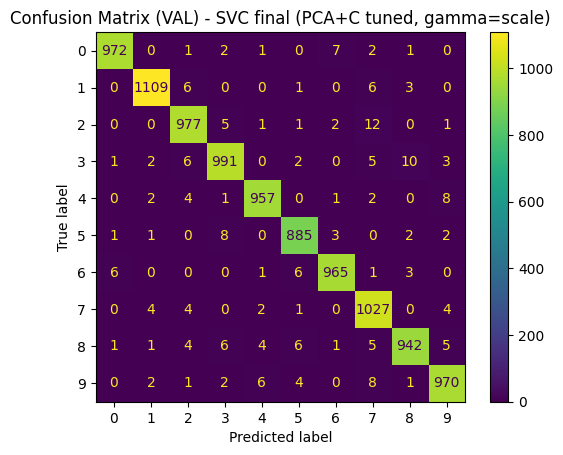

In [ ]:
BEST_PCA = 75
BEST_GAMMA = "scale"

# GridSearch över (PCA och gamma låst)
pipe_svc_gs_c = Pipeline([
    ("scaler", preprocessor),
    ("pca", PCA(n_components=BEST_PCA, random_state=42, svd_solver="randomized")),
    ("model", SVC(kernel="rbf", gamma="scale", cache_size=500))
])

hyperparams_grid_svc_c = {
    "model__C": [10, 11, 12, 13, 14, 15, 16]
}

gs_svc_c = GridSearchCV(
    estimator=pipe_svc_gs_c,
    param_grid=param_grid_step2,
    cv=3,
    scoring="accuracy",
    n_jobs=1,
    pre_dispatch=1,
    verbose=2,
    return_train_score=False
)

gs_svc_c.fit(X_train, y_train)

BEST_C = gs_svc_c.best_params_["model__C"]

print("\nSTEG 2 - Bästa params:", gs_svc_c.best_params_)
print("STEG 2 - Bästa CV-accuracy:", gs_svc_c.best_score_)


svc_final_model_c = Pipeline([
    ("scaler", preprocessor),
    ("pca", PCA(n_components=BEST_PCA, random_state=42, svd_solver="randomized")),
    ("model", SVC(kernel="rbf", C=BEST_C, gamma=BEST_GAMMA, cache_size=500))
])

svc_final_model_c.fit(X_train, y_train)

y_val_pred = svc_final_model_c.predict(X_val)
val_acc = accuracy_score(y_val, y_val_pred)

print("\nSTEG 3 - Slutmodellparametrar:")
print("PCA n_components:", BEST_PCA)
print("C:", BEST_C)
print("gamma:", BEST_GAMMA)
print("VAL accuracy (final):", val_acc)

cm = confusion_matrix(y_val, y_val_pred)
ConfusionMatrixDisplay(cm).plot(values_format="d")
plt.title("Confusion Matrix (VAL) - SVC final (PCA+C tuned, gamma=scale)")
plt.show()


# __Slutreultat: Final model:__ 

Jag har testat mig fram på en laptop med begränsade resurser, vilket gjorde att vissa körningar tog lång tid. Därför behövde jag begränsa antalet parametrar och kombinationer i mina tester. Efter flera dagars experiment och utvärdering landade jag i följande slutmodell:


- SVC (RBF)

### __Hyperparametrar:__
- gamma = "scale"
- PCA: n_components = 75
- C = 14

FINAL hyperparams:
  PCA = 75, C = 14, gamma = scale
TEST accuracy: 0.9768


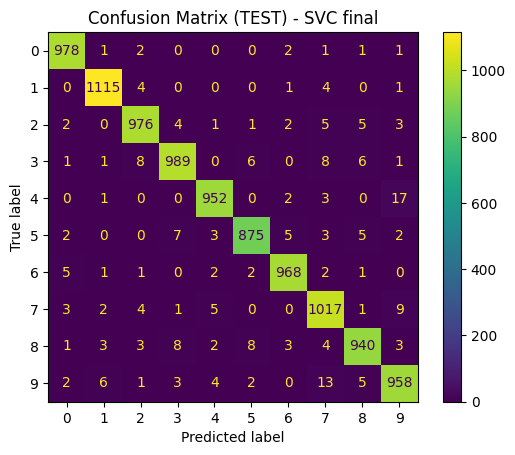

VAL accuracy: 0.9795


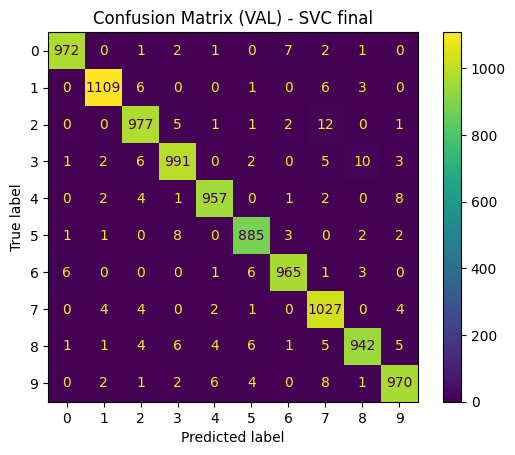

Accuracy on ALL data (in-sample): 0.9977


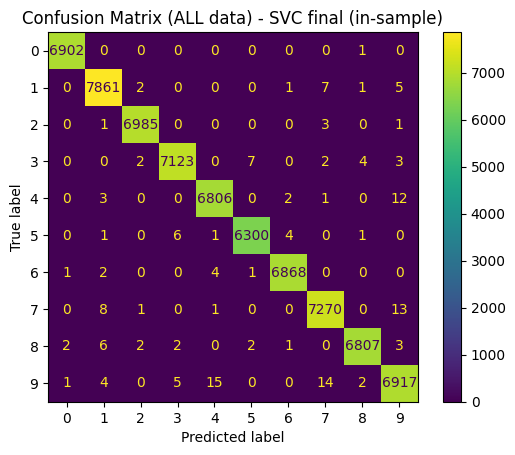

In [6]:
BEST_PCA = 75
BEST_C = 14
BEST_GAMMA = "scale"

final_model_svc = Pipeline([
    ("scaler", preprocessor),
    ("pca", PCA(n_components=BEST_PCA, random_state=42, svd_solver="randomized")),
    ("model", SVC(kernel="rbf", C=BEST_C, gamma=BEST_GAMMA, cache_size=500))
])

# Tränar på träningsdata och testar mot testdata
final_model_svc.fit(X_train, y_train)

y_test_pred = final_model_svc.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)

print("FINAL hyperparams:")
print(f"  PCA = {BEST_PCA}, C = {BEST_C}, gamma = {BEST_GAMMA}")
print("TEST accuracy:", test_acc)

cm_test = confusion_matrix(y_test, y_test_pred)
ConfusionMatrixDisplay(cm_test).plot(values_format="d")
plt.title("Confusion Matrix (TEST) - SVC final")
plt.show()

# Får ut accuracy på validation-data
y_val_pred = final_model_svc.predict(X_val)
val_acc = accuracy_score(y_val, y_val_pred)
print("VAL accuracy:", val_acc)

cm_val = confusion_matrix(y_val, y_val_pred)
ConfusionMatrixDisplay(cm_val).plot(values_format="d")
plt.title("Confusion Matrix (VAL) - SVC final")
plt.show()

#Tränar på hela dataset och visar ut testresultat på Accuracy
final_model_svc.fit(X, y)

y_all_pred = final_model_svc.predict(X)
all_acc = accuracy_score(y, y_all_pred)
print("Accuracy on ALL data (in-sample):", all_acc)

cm_all = confusion_matrix(y, y_all_pred)
ConfusionMatrixDisplay(cm_all).plot(values_format="d")
plt.title("Confusion Matrix (ALL data) - SVC final (in-sample)")
plt.show()


## Bilder som inte kunde läsas ut korrekt

In [7]:
#Antal fel
test_wrong_number = np.where(y_test_pred != y_test)[0]
n_wrong_test = len(test_wrong_number)

print(f"Antal fel (TEST): {n_wrong_test} av {len(y_test)}")
print(f"TEST accuracy (kontroll): {(len(y_test)-n_wrong_test)/len(y_test):.4f}")

# ===== VAL: felindex och antal fel =====
val_wrong_numbers = np.where(y_val_pred != y_val)[0]
n_wrong_val = len(val_wrong_numbers)

print(f"Antal fel (VAL): {n_wrong_val} av {len(y_val)}")
print(f"VAL accuracy (kontroll): {(len(y_val)-n_wrong_val)/len(y_val):.4f}")


Antal fel (TEST): 232 av 10000
TEST accuracy (kontroll): 0.9768
Antal fel (VAL): 205 av 10000
VAL accuracy (kontroll): 0.9795


### Analys av felklassificeringar (TEST) 
Presenterar ett urval av felaktigt predikterade exempel. Många är även svårtolkade för en människa (t.ex. brus, ofullständiga streck eller ovanliga skrivstilar). Detta kombineras med en normaliserad confusion matrix samt felprocent per siffra för att identifiera vilka siffror som oftast förväxlas och vilken klass modellen presterar svagast på. 

In [8]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

def fel_per_siffra(y_true, y_pred, n_classes=10):
    """
    Returnerar en tabell med antal, antal fel och felprocent per sann siffra.
    Sorterar automatiskt så sämst (högst fel%) kommer först.
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    count = np.bincount(y_true, minlength=n_classes)
    wrong = np.bincount(y_true[y_pred != y_true], minlength=n_classes)

    # Felprocent (0 om count=0)
    err_rate = np.divide(wrong, count, out=np.zeros(n_classes, dtype=float), where=count != 0)

    df = pd.DataFrame({
        "Siffra (sann)": np.arange(n_classes),
        "Antal": count,
        "Fel": wrong,
        "Fel%": (err_rate * 100).round(2)
    })

    return df.sort_values("Fel%", ascending=False).reset_index(drop=True)

def vanligaste_forvaxlingar(y_true, y_pred, top_k=10, n_classes=10):
    """
    Visar de vanligaste felen: sann -> pred, med antal.
    """
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(n_classes))
    np.fill_diagonal(cm, 0)  # ignorera korrekta träffar

    pairs = []
    for true_digit in range(n_classes):
        for pred_digit in range(n_classes):
            n = cm[true_digit, pred_digit]
            if n > 0:
                pairs.append((n, true_digit, pred_digit))

    pairs.sort(reverse=True)  # flest först

    for n, t, p in pairs[:top_k]:
        print(f"{t} → {p}: {n} st")

# ===== ANVÄNDNING =====
df = fel_per_siffra(y_test, y_test_pred)
print(df)

print("\nVanligaste förväxlingar:")
vanligaste_forvaxlingar(y_test, y_test_pred, top_k=10)


   Siffra (sann)  Antal  Fel  Fel%
0              9    994   36  3.62
1              8    975   35  3.59
2              3   1020   31  3.04
3              5    902   27  2.99
4              7   1042   25  2.40
5              4    975   23  2.36
6              2    999   23  2.30
7              6    982   14  1.43
8              1   1125   10  0.89
9              0    986    8  0.81

Vanligaste förväxlingar:
4 → 9: 17 st
9 → 7: 13 st
7 → 9: 9 st
8 → 5: 8 st
8 → 3: 8 st
3 → 7: 8 st
3 → 2: 8 st
5 → 3: 7 st
9 → 1: 6 st
3 → 8: 6 st
